In [32]:
%matplotlib inline

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import pydicom
import os
import scipy.ndimage
import matplotlib.pyplot as plt

from skimage import measure, morphology
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

# Some constants 
INPUT_FOLDER = '/home/alejandrodf1/Documents/theory_project/teoria_project/data/raw/10.000000-late-10134'
patients = os.listdir(INPUT_FOLDER)
patients.sort()

In [33]:
def load_scan(path):
    slices = [pydicom.read_file(path + '/' + s) for s in os.listdir(path)]
    slices.sort(key = lambda x: float(x.ImagePositionPatient[2]))
    try:
        slice_thickness = np.abs(slices[0].ImagePositionPatient[2] - slices[1].ImagePositionPatient[2])
    except:
        slice_thickness = np.abs(slices[0].SliceLocation - slices[1].SliceLocation)
        
    for s in slices:
        s.SliceThickness = slice_thickness
        
    return slices

In [48]:
slices=load_scan(INPUT_FOLDER)
len(slices)

154

In [49]:
def get_pixels_hu(slices):
    image = np.stack([s.pixel_array for s in slices])
    # Convert to int16 (from sometimes int16), 
    # should be possible as values should always be low enough (<32k)
    image = image.astype(np.int16)

    # Set outside-of-scan pixels to 0
    # The intercept is usually -1024, so air is approximately 0
    image[image == -2000] = 0
    
    # Convert to Hounsfield units (HU)
    for slice_number in range(len(slices)):
        
        intercept = slices[slice_number].RescaleIntercept
        slope = slices[slice_number].RescaleSlope
        
        if slope != 1:
            image[slice_number] = slope * image[slice_number].astype(np.float64)
            image[slice_number] = image[slice_number].astype(np.int16)
            
        image[slice_number] += np.int16(intercept)
    
    return np.array(image, dtype=np.int16)

In [24]:
get_pixels_hu(slices=slices)

array([[[-1024, -1024, -1024, ..., -1024, -1024, -1024],
        [-1024, -1024, -1024, ..., -1024, -1024, -1024],
        [-1024, -1024, -1024, ..., -1024, -1024, -1024],
        ...,
        [-1024, -1024, -1024, ..., -1024, -1024, -1024],
        [-1024, -1024, -1024, ..., -1024, -1024, -1024],
        [-1024, -1024, -1024, ..., -1024, -1024, -1024]],

       [[-1024, -1024, -1024, ..., -1024, -1024, -1024],
        [-1024, -1024, -1024, ..., -1024, -1024, -1024],
        [-1024, -1024, -1024, ..., -1024, -1024, -1024],
        ...,
        [-1024, -1024, -1024, ..., -1024, -1024, -1024],
        [-1024, -1024, -1024, ..., -1024, -1024, -1024],
        [-1024, -1024, -1024, ..., -1024, -1024, -1024]],

       [[-1024, -1024, -1024, ..., -1024, -1024, -1024],
        [-1024, -1024, -1024, ..., -1024, -1024, -1024],
        [-1024, -1024, -1024, ..., -1024, -1024, -1024],
        ...,
        [-1024, -1024, -1024, ..., -1024, -1024, -1024],
        [-1024, -1024, -1024, ..., -1024, -10

In [50]:
patients[0]
INPUT_FOLDER + patients[0]
load_scan(INPUT_FOLDER+patients[0])

FileNotFoundError: [Errno 2] No such file or directory: '/home/alejandrodf1/Documents/theory_project/teoria_project/data/raw/10.000000-late-101341-001.dcm'

In [36]:
dest_dir = os.path.expanduser('~')
dest_path = os.path.join(INPUT_FOLDER, patients[0])
print(dest_path)
print(os.path.isfile(dest_path))
first = get_pixels_hu(slices=slices)
first[0]

/home/alejandrodf1/Documents/theory_project/teoria_project/data/raw/10.000000-late-10134/1-001.dcm
True


array([[-1024, -1024, -1024, ..., -1024, -1024, -1024],
       [-1024, -1024, -1024, ..., -1024, -1024, -1024],
       [-1024, -1024, -1024, ..., -1024, -1024, -1024],
       ...,
       [-1024, -1024, -1024, ..., -1024, -1024, -1024],
       [-1024, -1024, -1024, ..., -1024, -1024, -1024],
       [-1024, -1024, -1024, ..., -1024, -1024, -1024]], dtype=int16)

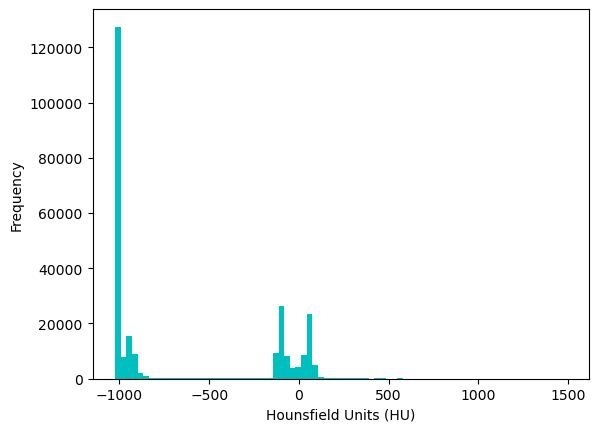

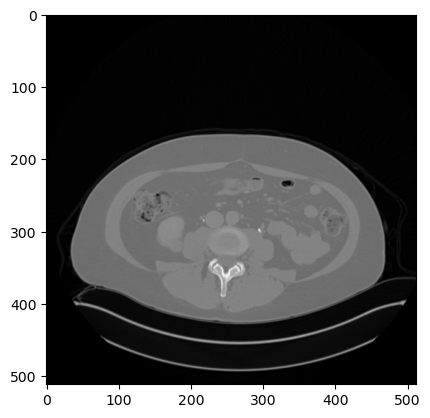

(512, 512)


In [56]:
first_patient = slices[1]
first_patient_pixels = first[1]
plt.hist(first[1].flatten(), bins=80, color='c')
plt.xlabel("Hounsfield Units (HU)")
plt.ylabel("Frequency")
plt.show()

# Show some slice in the middle
plt.imshow(first[80], cmap=plt.cm.gray)
plt.show()

print(first[0].shape)

In [52]:
def resample(image, scan, new_spacing=[1,1,1]):
    # Determine current pixel spacing
    spacing = np.array([scan[0].SliceThickness] + scan[0].PixelSpacing, dtype=np.float32)

    resize_factor = spacing / new_spacing
    new_real_shape = image.shape * resize_factor
    new_shape = np.round(new_real_shape)
    real_resize_factor = new_shape / image.shape
    new_spacing = spacing / real_resize_factor
    
    image = scipy.ndimage.interpolation.zoom(image, real_resize_factor, mode='nearest')
    
    return image, new_spacing

In [55]:
pix_resampled, spacing = resample(first_patient_pixels, first_patient,new_spacing=[1,1,1])
#pix_resampled, spacing = resample(first[0], slices[0],[1,1,1])
print("Shape before resampling\t", first[0].shape)
print("Shape after resampling\t", pix_resampled[0].shape)

KeyError: (0000, 0000)